In [4]:
# SLM Auto Importer v4 debugv1
# slimmed down from v3 - 
import openpyxl 
import string
import time
import pandas as pd
from pandas import ExcelWriter
import numpy as np
from openpyxl import load_workbook
from openpyxl import Workbook
from openpyxl import cell
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table,Paragraph
from openpyxl.utils import get_column_letter
import xlsxwriter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import Image
from os import listdir, walk
from os.path import isfile, join
import tkinter as tk
from tkinter import *
import win32com
# from win32com import client
import shutil

# import win32com.client


C:\Users\jPfitsch\AppData\Local\Temp\ipykernel_30124\2398909239.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [178]:
def format_SLMdata(srs_data):
    srs_thirdoct = srs_data.iloc[7] # hardcoded to SLM export data format
    srs_thirdoct = srs_thirdoct[13:31] # select only the frequency bands of interest
    return srs_thirdoct


In [131]:
def calc_ATL_val(srs_overalloct,rec_overalloct,bkgrnd_overalloct,rt_thirty,parition_area,recieve_roomvol):
    ASTC_vollimit = 883
    if recieve_roomvol > ASTC_vollimit:
        print('Using NIC calc, room volume too large')
    # constant = np.int32(20.047*np.sqrt(273.15+20))
    # intermed = 30/rt_thirty ## why did i do this? not right....sabines calc is off
    # thisval = np.int32(recieve_roomvol*intermed)
    # sabines =thisval/constant
    sabines = 0.049*(recieve_roomvol/rt_thirty)  # this produces accurate sabines values
    recieve_corr = list()
    recieve_vsBkgrnd = rec_overalloct - bkgrnd_overalloct
    for i, val in enumerate(recieve_vsBkgrnd):
        if val < 5:
            recieve_corr.append(rec_overalloct.iloc[i]-2)
        elif val < 10:
            recieve_corr.append(np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))
        else:
            recieve_corr.append(rec_overalloct.iloc[i])
    recieve_corr = np.round(recieve_corr,1)
    ATL_val = srs_overalloct - recieve_corr+10*(np.log10(parition_area/sabines))
    return ATL_val

In [132]:
testplan_path ='//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Documents/TestPlan_Kaulu_ASTM_testingv1.xlsx'
Aslmdatapath = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/A_Meter/'
Eslmdatapath = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/E_Meter/'
testplanfile = pd.read_excel(testplan_path)
testnums = testplanfile['Test_Label'] ## Determines the labels and number of excel files copied
curr_test = testplanfile.iloc[0]
print(curr_test)    

Area                                              NaN
Area Label                                        NaN
Test_Label                                      1.1.1
Source_Room                      2nd Floor Great Room
Receiving_Room           1st Floor Great Room/Kitchen
Partition_Type                          Floor-ceiling
Design_STC                                         47
Test_Date                         2024-04-04 00:00:00
Report_Date                       2024-04-15 00:00:00
Source                                           A029
Recieve                                          E264
BNL                                              E263
RT                                               E140
Position1                                        E265
Position2                                        E266
Position3                                        E267
Position4                                        E268
Carpet                                           E269
SourceTap                   

In [133]:
def pull_testplan_data(self,curr_test):
    # AIIC_test = curr_test['AIIC']
    # NIC_test = curr_test['NIC'] 
    # ASTC_test = curr_test['ASTC']

    if int(curr_test['source room vol']) >= 5300 or int(curr_test['receive room vol']) >= 5300:
        NICreporting_Note = 'The receiver and/or source room had a volume exceeding 150 m3 (5,300 cu. ft.), and the absorption of the receiver and/or source room was greater than the maximum allowed per E336-16, Paragraph 9.4.1.2.'
    elif int(curr_test['source room vol']) <= 833 or int(curr_test['receive room vol']) <= 833:
        NICreporting_Note = 'The receiver and/or source room has a volume less than the minimum volume requirement of 25 m3 (883 cu. ft.).'
    else:
        NICreporting_Note = '---'

    room_properties = pd.DataFrame(
        {
            "Source Room Name": curr_test['Source Room'],
            "Recieve Room Name": curr_test['Receiving Room'],
            "Testdate": curr_test['Test Date'],
            "ReportDate": curr_test['Report Date'],
            "Project Name": curr_test['Project Name'],
            "Test number": curr_test['Test Label'],
            "Source Vol" : curr_test['source room vol'],
            "Recieve Vol": curr_test['receive room vol'],
            "Partition area": curr_test['partition area'],
            "Partition dim.": curr_test['partition dim'],
            "Source room Finish" : curr_test['source room finish'],
            "Recieve room Finish": curr_test['receive room finish'],
            "Srs Floor Descrip.": curr_test['srs_floor'],
            "Srs Ceiling Descrip.": curr_test['srs_ceiling'],
            "Srs Walls Descrip.": curr_test['srs_Walls'],
            "Rec Floor Descrip.": curr_test['rec_floor'],
            "Rec Ceiling Descrip.": curr_test['rec_ceiling'],
            "Rec Walls Descrip.": curr_test['rec_Wall'],          
            "Tested Assembly": curr_test['tested assembly'],
            "Expected Performance": curr_test['expected performance'],
            "Annex 2 used?": curr_test['Annex 2 used?'],
            "Test assem. type": curr_test['Test assembly Type'],
            "NIC reporting Note": NICreporting_Note
        },
        index=[0]
        )
    
    
    if curr_test['AIIC_test'] == 1:
        print("AIIC testing enabled, copying data...")
### IIC variables  #### When extending to IIC data
        find_source = curr_test['Source']
        find_rec = curr_test['Recieve '] #trailing whitespace? be sure to verify this is consistent in the excel file
        find_BNL = curr_test['BNL']
        find_RT = curr_test['RT']
        find_posOne = curr_test['Position1']
        find_posTwo = curr_test['Position2']
        find_posThree = curr_test['Position3']
        find_posFour = curr_test['Position4']
        find_poscarpet = curr_test['Carpet']
        find_Tapsrs = curr_test['SourceTap']
        srs_data = pull_testdata(self,find_source,'-831_Data.')
        recive_data = pull_testdata(self,find_rec,'-831_Data.')
        bkgrnd_data = pull_testdata(self,find_BNL,'-831_Data.')
        rt = pull_testdata(self,find_RT,'-RT_Data.')
        AIIC_pos1 = pull_testdata(self,find_posOne,'-831_Data.')
        AIIC_pos2 = pull_testdata(self,find_posTwo,'-831_Data.')
        AIIC_pos3 = pull_testdata(self,find_posThree,'-831_Data.')
        AIIC_pos4 = pull_testdata(self,find_posFour,'-831_Data.')
        AIIC_carpet = pull_testdata(self,find_poscarpet,'-831_Data.')
        AIIC_source = pull_testdata(self,find_Tapsrs,'-831_Data.')
        
        single_AIICtest_data = {
            'srs_data': pd.DataFrame(srs_data),
            'recive_data': pd.DataFrame(recive_data),
            'bkgrnd_data': pd.DataFrame(bkgrnd_data),
            'rt': pd.DataFrame(rt),
            'AIIC_pos1': pd.DataFrame(AIIC_pos1),
            'AIIC_pos2': pd.DataFrame(AIIC_pos2),
            'AIIC_pos3': pd.DataFrame(AIIC_pos3),
            'AIIC_pos4': pd.DataFrame(AIIC_pos4),
            'AIIC_source': pd.DataFrame(AIIC_source),
            'AIIC_carpet': pd.DataFrame(AIIC_carpet),
            'room_properties': pd.DataFrame(room_properties)
        }
        return single_AIICtest_data
    
    elif curr_test['ASTC_test'] == 1:
        print("AIIC data not enabled")
        print("ASTC or NIC test enabled, copying data...")

        single_ASTCtest_data = {
            'srs_data': pd.DataFrame(srs_data),
            'recive_data': pd.DataFrame(recive_data),
            'bkgrnd_data': pd.DataFrame(bkgrnd_data),
            'rt': pd.DataFrame(rt),
            'room_properties': pd.DataFrame(room_properties)
            }
        return single_ASTCtest_data
        
       

    elif curr_test['NIC_test'] == 1:
        srs_data = pull_testdata(self,curr_test['Source'],'-831_Data.')
        recive_data = pull_testdata(self, curr_test['Recieve '],'-831_Data.')
        bkgrnd_data = pull_testdata(self,curr_test['BNL'],'-831_Data.')
        rt = pull_testdata(self,curr_test['RT'],'-RT_Data.')

        single_NICtest_data = {
            'srs_data': pd.DataFrame(srs_data),
            'recive_data': pd.DataFrame(recive_data),
            'bkgrnd_data': pd.DataFrame(bkgrnd_data),
            'rt': pd.DataFrame(rt),
            'room_properties': pd.DataFrame(room_properties)
            }
        return single_NICtest_data
    

In [134]:
# need to modify for testing without GUI
def RAW_SLM_datapull(find_datafile, datatype):
    # pass datatype as '-831_Data.' or '-RT_Data.' to pull the correct data
    raw_testpaths = {
        'A': Aslmdatapath,
        'E': Eslmdatapath,
        # 'A': self.slm_data_a_path
    }
    datafiles = {}
    for key, path in raw_testpaths.items():
        datafiles[key] = [f for f in listdir(path) if isfile(join(path, f))]

    if find_datafile[0] in datafiles:
        print('data found')
        print(datafiles[find_datafile[0]])
        datafile_num = datatype + find_datafile[1:] + '.xlsx'
        print(datafile_num)
        slm_found = [x for x in datafiles[find_datafile[0]] if datafile_num in x]
        slm_found[0] = raw_testpaths[find_datafile[0]] + slm_found[0]  # If this line errors, the test file is mislabeled or doesn't exist 

    print(slm_found[0])
    if datatype == '-831_Data.':
        srs_data = pd.read_excel(slm_found[0], sheet_name='OBA')
    elif datatype == '-RT_Data.':
        srs_data = pd.read_excel(slm_found[0], sheet_name='Summary')  # data must be in Summary tab for RT meas.
    # srs_data = pd.read_excel(slm_found[0], sheet_name='OBA')  # data must be in OBA tab
    # potentially need a write to excel here...similar to previous function
    # just for 
    return srs_data

In [27]:
# this just needs to validate that the proper test data is pulled from the test dataframe such that ATL and 
find_test = '1.1.1'
# find_test = single_test_text_input_value
mask = testplanfile.applymap(lambda x: find_test in x if isinstance(x,str) else False).to_numpy()
indices = np.argwhere(mask) 
# print(indices)

index = indices[0,0]
# print(index)
# status_text_box.insert(tk.END,testplanfile.iloc[index])
foundtest = testplanfile.iloc[index]
# print the found test in the status box
# status_text_box.insert(tk.END, foundtest) # must come before mainloop
# print(foundtest)
report_string = '_'+find_test+'_' 
# status_text_box.insert(tk.END, f"Report string: '{report_string}'")
# status_text_box.insert(tk.END, f"Report list: '{reports}'")
# curr_report_file = [x for x in reports if report_string in x]
# print('Current report file: ',curr_report_file)
# print(curr_report_file[0]) #print the name of the report file being used
print('Current Test:', foundtest)
# curr_test = testplanfile.iloc[index]

# single_AIIC_test_data = pull_testplan_data(curr_test)

Current Test: Area                                              NaN
Area Label                                        NaN
Test_Label                                      1.1.1
Source_Room                      2nd Floor Great Room
Receiving_Room           1st Floor Great Room/Kitchen
Partition_Type                          Floor-ceiling
Design_STC                                         47
Test_Date                         2024-04-04 00:00:00
Report_Date                       2024-04-15 00:00:00
Source                                           A029
Recieve                                          E264
BNL                                              E263
RT                                               E140
Position1                                        E265
Position2                                        E266
Position3                                        E267
Position4                                        E268
Carpet                                           E269
SourceTap     

C:\Users\jPfitsch\AppData\Local\Temp\ipykernel_30124\4280048954.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = testplanfile.applymap(lambda x: find_test in x if isinstance(x,str) else False).to_numpy()


In [135]:

room_properties = pd.DataFrame(
    {
        "Source Room Name": curr_test['Source_Room'],
        "Recieve Room Name": curr_test['Receiving_Room'],
        "Testdate": curr_test['Test_Date'],
        "ReportDate": curr_test['Report_Date'],
        "Project Name": curr_test['Project_Name'],
        "Test number": curr_test['Test_Label'],
        "Source Vol" : curr_test['source_room_vol'],
        "Recieve Vol": curr_test['receive_room_vol'],
        "Partition area": curr_test['partition_area'],
        "Partition dim.": curr_test['partition_dim'],
        "Source room Finish" : curr_test['source_room_finish'],
        "Recieve room Finish": curr_test['receive_room_finish'],
        "Srs Floor Descrip.": curr_test['srs_floor'],
        "Srs Ceiling Descrip.": curr_test['srs_ceiling'],
        "Srs Walls Descrip.": curr_test['srs_Walls'],
        "Rec Floor Descrip.": curr_test['rec_floor'],
        "Rec Ceiling Descrip.": curr_test['rec_ceiling'],
        "Rec Walls Descrip.": curr_test['rec_Wall'],          
        "Tested Assembly": curr_test['tested_assembly'],
        "Expected Performance": curr_test['expected_performance'],
        "Annex 2 used?": curr_test['Annex_2_used?'],
        "Test assem. type": curr_test['Test_assembly_Type'],
        "AIIC_test": curr_test['AIIC_test'],
        "NIC_test": curr_test['NIC_test'],
        "ASTC_test": curr_test['ASTC_test']
        # "NIC reporting Note": NICreporting_Note
    },
    index=[0]
    )


In [179]:
# single_test_dataframe = pull_testplan_data(curr_test) 
## these are file numbers in the xexcel fname
find_source = curr_test['Source']
find_rec = curr_test['Recieve '] #trailing whitespace? be sure to verify this is consistent in the excel file
find_BNL = curr_test['BNL']
find_RT = curr_test['RT']
find_posOne = curr_test['Position1']
find_posTwo = curr_test['Position2']
find_posThree = curr_test['Position3']
find_posFour = curr_test['Position4']
find_poscarpet = curr_test['Carpet']
find_Tapsrs = curr_test['SourceTap']

# these are pulling the dataframes from the excel path 
s_data = RAW_SLM_datapull(find_source,'-831_Data.')
recive_data = RAW_SLM_datapull(find_rec,'-831_Data.')
bkgrnd_data = RAW_SLM_datapull(find_BNL,'-831_Data.')
rt = RAW_SLM_datapull(find_RT,'-RT_Data.')
AIIC_pos1 = RAW_SLM_datapull(find_posOne,'-831_Data.')
AIIC_pos2 = RAW_SLM_datapull(find_posTwo,'-831_Data.')
AIIC_pos3 = RAW_SLM_datapull(find_posThree,'-831_Data.')
AIIC_pos4 = RAW_SLM_datapull(find_posFour,'-831_Data.')
AIIC_carpet = RAW_SLM_datapull(find_poscarpet,'-831_Data.')
AIIC_source = RAW_SLM_datapull(find_Tapsrs,'-831_Data.')

single_AIICtest_data = {
    'srs_data': pd.DataFrame(s_data),
    'recive_data': pd.DataFrame(recive_data),
    'bkgrnd_data': pd.DataFrame(bkgrnd_data),
    'rt': pd.DataFrame(rt),
    'AIIC_pos1': pd.DataFrame(AIIC_pos1),
    'AIIC_pos2': pd.DataFrame(AIIC_pos2),
    'AIIC_pos3': pd.DataFrame(AIIC_pos3),
    'AIIC_pos4': pd.DataFrame(AIIC_pos4),
    'AIIC_source': pd.DataFrame(AIIC_source),
    'AIIC_carpet': pd.DataFrame(AIIC_carpet),
    'room_properties': pd.DataFrame(room_properties)
}
        # return single_AIICtest_data

data found
['831_0002237-20240404 135527-831_Data.028.xlsx', '831_0002237-20240404 144640-831_Data.029.xlsx', '831_0002237-20240404 145015-831_Data.030.xlsx', '831_0002237-20240404 150105-831_Data.031.xlsx', '831_0002237-20240404 151353-831_Data.032.xlsx', '831_0002237-20240404 153328-831_Data.033.xlsx', '831_0002237-20240404 153915-831_Data.034.xlsx', '831_0002237-20240404 154453-831_Data.035.xlsx']
-831_Data.029.xlsx
//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/A_Meter/831_0002237-20240404 144640-831_Data.029.xlsx
data found
['831_0004328-20240404 135404-831_Data.261.xlsx', '831_0004328-20240404 144251-831_Data.262.xlsx', '831_0004328-20240404 144406-831_Data.263.xlsx', '831_0004328-20240404 144622-831_Data.264.xlsx', '831_0004328-20240404 144958-831_Data.265.xlsx', '831_0004328-20240404 145232-831_Data.266.xlsx', '831_0004328-20240404 145410-831_Data.267.xlsx', '831_0004328-20240404 145602-831_Data.268.xlsx', '831_0004328-20240404

In [137]:
### NEW REWORK OF NR CALC ### 
def calc_NR_new(srs_overalloct, rec_overalloct, bkgrnd_overalloct, rt_thirty, recieve_roomvol, NIC_vollimit,testtype):
    NIC_vollimit = 150  # cu. ft.
    if recieve_roomvol > NIC_vollimit:
        print('Using NIC calc, room volume too large')
    #constant = np.int32(20.047 * np.sqrt(273.15 + 20)) #  wut is this...
    # intermed = 30 / rt_thirty  # was i compensating for RT calcs?
   
    sabines = 0.049*(recieve_roomvol/rt_thirty)  # this produces accurate sabines values

    # thisval = np.int32(recieve_roomvol * intermed)
    # sabines = thisval / constant
    # sabines = np.round(sabines*(0.921))        
    recieve_corr = list()
    recieve_vsBkgrnd = rec_overalloct - bkgrnd_overalloct
    recieve_vsBkgrnd = np.round(recieve_vsBkgrnd,1)
    print('rec vs background:',recieve_vsBkgrnd)
    if testtype == 'AIIC':
        for i, val in enumerate(recieve_vsBkgrnd):
            if val < 5:
                recieve_corr.append(rec_overalloct.iloc[i]-2)
            else:
                recieve_corr.append(10*np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))   
    elif testtype == 'ASTC':
        for i, val in enumerate(recieve_vsBkgrnd):
            print('val:', val)
            print('count: ', i)
            if val < 5:
                recieve_corr.append(rec_overalloct.iloc[i]-2)
            elif val < 10:
                recieve_corr.append(10*np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))
            else:
                recieve_corr.append(rec_overalloct.iloc[i])
        # print('-=-=-=-=-')
        # print('recieve_corr: ',recieve_corr)
    recieve_corr = np.round(recieve_corr,1)
    NR_val = srs_overalloct - recieve_corr
    # Normalized_recieve = recieve_corr / srs_overalloct
    sabines = pd.to_numeric(sabines, errors='coerce')
    Normalized_recieve = recieve_corr-10*(np.log10(108/sabines))
    return NR_val, sabines,recieve_corr, Normalized_recieve

In [180]:
onethird_srs_tapper = format_SLMdata(single_AIICtest_data['AIIC_source']) 
onethird_srs = format_SLMdata(single_AIICtest_data['srs_data'])
onethird_rec = format_SLMdata(single_AIICtest_data['recive_data'])
# 
# onethird_rec_pos1 = format_SLMdata(single_AIICtest_data['AIIC_pos1'])# this needs to be an average of the 4 tapper positions, stored in a dataframe of the average of the 4 dataframes octave band results. 

average_pos = []
for i in range(1, 5):
    pos_input = f'AIIC_pos{i}'
    pos_data = format_SLMdata(single_AIICtest_data[pos_input])
    average_pos.append(pos_data)

average_pos = pd.concat(average_pos, axis=1)


In [181]:
print(average_pos)

                7     7     7     7
Unnamed: 13  49.0  48.2  49.4  49.6
Unnamed: 14  47.7  48.7  47.5  48.4
Unnamed: 15  42.4  43.5  42.9  42.6
Unnamed: 16  38.6  39.5  39.2  41.0
Unnamed: 17  43.0  41.5  42.6  42.9
Unnamed: 18  46.8  42.6  47.1  46.0
Unnamed: 19  40.6  38.4  39.6  39.8
Unnamed: 20  33.7  33.2  33.3  34.9
Unnamed: 21  30.2  28.8  29.4  31.4
Unnamed: 22  28.1  27.4  28.4  29.8
Unnamed: 23  27.5  26.4  27.7  28.5
Unnamed: 24  26.9  25.8  27.7  28.0
Unnamed: 25  27.2  25.4  27.5  27.5
Unnamed: 26  23.8  23.1  24.6  25.1
Unnamed: 27  20.6  21.0  21.2  22.3
Unnamed: 28  18.5  19.7  19.3  20.8
Unnamed: 29  17.5  19.0  18.4  20.5
Unnamed: 30  16.2  18.3  17.4  19.0


In [182]:
print(len(average_pos))

18


In [183]:
# print(average_pos.iloc[0,0])
# print(average_pos.iloc[0,1])
# result = 10 * np.log10((10**(freqbin.iloc[0,0]/10) + 10**(freqbin[0,1]/10) + 10**(freqbin[0,2]/10) + 10**(freqbin[0,3]/10)) / 4)

onethird_rec_Total = []
for i in range(len(average_pos)):
    freqbin =  average_pos.iloc[i,:]
    # freqbin=pd.to_numeric(freqbin, errors='coerce')
    print(freqbin)
    # print(freqbin.iloc[0])
    onethird_rec_Total.append(10 * np.log10((10**(freqbin.iloc[0]/10) + 10**(freqbin.iloc[1]/10) + 10**(freqbin.iloc[2]/10) + 10**(freqbin.iloc[3]/10)) / 4))
    print(onethird_rec_Total)
    

onethird_rec_Total = np.round(onethird_rec_Total,1)
# onethird_rec_Total = pd.DataFrame(onethird_rec_Total)


print('tap total:', onethird_rec_Total) # need to round this to the nearest 0.1

7    49.0
7    48.2
7    49.4
7    49.6
Name: Unnamed: 13, dtype: object
[49.08216331619687]
7    47.7
7    48.7
7    47.5
7    48.4
Name: Unnamed: 14, dtype: object
[49.08216331619687, 48.102873379554055]
7    42.4
7    43.5
7    42.9
7    42.6
Name: Unnamed: 15, dtype: object
[49.08216331619687, 48.102873379554055, 42.87021281657218]
7    38.6
7    39.5
7    39.2
7    41.0
Name: Unnamed: 16, dtype: object
[49.08216331619687, 48.102873379554055, 42.87021281657218, 39.668894931805994]
7    43.0
7    41.5
7    42.6
7    42.9
Name: Unnamed: 17, dtype: object
[49.08216331619687, 48.102873379554055, 42.87021281657218, 39.668894931805994, 42.539038502752106]
7    46.8
7    42.6
7    47.1
7    46.0
Name: Unnamed: 18, dtype: object
[49.08216331619687, 48.102873379554055, 42.87021281657218, 39.668894931805994, 42.539038502752106, 45.942733883571364]
7    40.6
7    38.4
7    39.6
7    39.8
Name: Unnamed: 19, dtype: object
[49.08216331619687, 48.102873379554055, 42.87021281657218, 39.66889493180

In [184]:



## this needs to be a logarithmic averafge of the 4 tapper positions
# onethird_rec_Total = sum(average_pos) / len(average_pos)

# # average_pos = pd.to_numeric(average_pos, errors='coerce')
# onethird_rec_Total = np.exp(np.mean(np.log(10**(average_pos/10))))

# onethird_rec_Total = pd.to_numeric(onethird_rec_Total, errors='coerce')


onethird_bkgrd = format_SLMdata(single_AIICtest_data['bkgrnd_data'])

print('background total: ',onethird_bkgrd)
print('tap level minus bkground: ',onethird_rec_Total-onethird_bkgrd)

rt_thirty = single_AIICtest_data['rt']['Unnamed: 10'][25:41]/1000

# need to pass testtype to differentiate between AIIC and ASTC calculations
# testtype = 'AIIC'


ATL_val = calc_ATL_val(onethird_srs, onethird_rec_Total, onethird_bkgrd,rt_thirty,room_properties['Partition area'][0],room_properties['Recieve Vol'][0])

background total:  Unnamed: 13    35.4
Unnamed: 14    39.2
Unnamed: 15    33.0
Unnamed: 16    37.1
Unnamed: 17    34.4
Unnamed: 18    33.7
Unnamed: 19    33.3
Unnamed: 20    32.5
Unnamed: 21    31.2
Unnamed: 22    30.6
Unnamed: 23    29.6
Unnamed: 24    28.9
Unnamed: 25    28.5
Unnamed: 26    24.9
Unnamed: 27    20.6
Unnamed: 28    18.5
Unnamed: 29    17.6
Unnamed: 30    15.1
Name: 7, dtype: object
tap level minus bkground:  Unnamed: 13    13.7
Unnamed: 14     8.9
Unnamed: 15     9.9
Unnamed: 16     2.6
Unnamed: 17     8.1
Unnamed: 18    12.2
Unnamed: 19     6.4
Unnamed: 20     1.3
Unnamed: 21    -1.1
Unnamed: 22    -2.1
Unnamed: 23    -2.0
Unnamed: 24    -1.7
Unnamed: 25    -1.5
Unnamed: 26    -0.7
Unnamed: 27     0.7
Unnamed: 28     1.2
Unnamed: 29     1.4
Unnamed: 30     2.7
Name: 7, dtype: object
Using NIC calc, room volume too large


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
calc_NR, sabines, corrected_recieve,Nrec_ANISPL = calc_NR_new(onethird_srs, onethird_rec_Total, onethird_bkgrd, rt_thirty,room_properties['Recieve Vol'][0],NIC_vollimit=883,testtype='AIIC')


In [139]:
print(average_pos)

[[49.  47.7 42.4 38.6 43.  46.8 40.6 33.7 30.2 28.1 27.5 26.9 27.2 23.8
  20.6 18.5 17.5]
 [48.2 48.7 43.5 39.5 41.5 42.6 38.4 33.2 28.8 27.4 26.4 25.8 25.4 23.1
  21.  19.7 19. ]
 [49.4 47.5 42.9 39.2 42.6 47.1 39.6 33.3 29.4 28.4 27.7 27.7 27.5 24.6
  21.2 19.3 18.4]
 [49.6 48.4 42.6 41.  42.9 46.  39.8 34.9 31.4 29.8 28.5 28.  27.5 25.1
  22.3 20.8 20.5]]


In [120]:
print(single_AIICtest_data['room_properties']['Partition area'][0])

428.0


In [80]:
## debugged, functional ATL calculation
def calc_ATL_val(srs_overalloct,rec_overalloct,bkgrnd_overalloct,parition_area,recieve_roomvol,sabines):
    ASTC_vollimit = 883
    sabines
    if recieve_roomvol > ASTC_vollimit:
        print('Using NIC calc, room volume too large')
        # need to do something with this hah
    recieve_corr = list()
    bkgrnd_overalloct = pd.to_numeric(bkgrnd_overalloct, errors='coerce')
    bkgrnd_overalloct = np.array(bkgrnd_overalloct)
    rec_overalloct = pd.to_numeric(rec_overalloct, errors='coerce')
    rec_overalloct = np.array(rec_overalloct)
    
    recieve_vsBkgrnd = rec_overalloct - bkgrnd_overalloct
    print('recieve vs background:',recieve_vsBkgrnd)
    recieve_vsBkgrnd = pd.to_numeric(recieve_vsBkgrnd, errors='coerce')
    recieve_vsBkgrnd = np.array(recieve_vsBkgrnd)

    for i, val in enumerate(recieve_vsBkgrnd):
        if val < 5:
            recieve_corr.append(rec_overalloct[i]-2)
        elif val < 10:
            recieve_corr.append(10*np.log10(10**(rec_overalloct[i]/10)-10**(bkgrnd_overalloct[i]/10)))
        else:
            recieve_corr.append(rec_overalloct[i])
    recieve_corr = np.round(recieve_corr,1)
    print('corrected recieve: ',recieve_corr)
    
    sabines = pd.to_numeric(sabines, errors='coerce')
    #convert sabines to array
    sabines = np.array(sabines)
    sabines = np.round(sabines)
    print('sabines: ',sabines)
    srs_overalloct = pd.to_numeric(srs_overalloct, errors='coerce')
    srs_overalloct = np.array(srs_overalloct)
    print('srs_overalloct: ',srs_overalloct)
    ATL_val = srs_overalloct - recieve_corr+10*(np.log10(parition_area/sabines))
    ATL_val = np.round(ATL_val,1)
    return ATL_val,recieve_corr

In [58]:
# receive values for ATL are recieve pink noise, not total tapper level
ATL_val,corrected_STC_recieve = calc_ATL_val(onethird_srs, onethird_rec, onethird_bkgrd,room_properties['Partition area'][0],room_properties['Recieve Vol'][0],sabines)

Using NIC calc, room volume too large
recieve vs background: [40.3 40.  28.5 27.2 23.9 19.4 15.  10.8  9.8  5.5  3.5  1.7  2.6  3.5
  3.1  2.1]
corrected recieve:  [79.5 73.  65.6 61.6 57.6 52.7 47.5 42.  39.9 33.7 30.4 28.2 25.5 22.1
 19.6 17.7]
sabines:  [229. 306. 194. 189. 170. 144. 153. 170. 173. 150. 133. 127. 132. 139.
 138. 139.]
srs_overalloct:  [95.  91.4 90.  91.6 89.7 88.8 84.7 82.5 84.5 83.  83.8 81.4 79.8 82.4
 84.  85. ]


In [81]:
print(ATL_val)

[18.2 19.9 27.8 33.5 36.1 40.8 41.7 44.5 48.5 53.9 58.5 58.5 59.4 65.2
 69.3 72.2]


In [79]:
print('corrected STC recieve: ',corrected_STC_recieve)
Nrec_ANISPL = pd.to_numeric(Nrec_ANISPL, errors='coerce')
print('Nrec ANISPL: ',Nrec_ANISPL)

corrected STC recieve:  [79.5 73.  65.6 61.6 57.6 52.7 47.5 42.  39.9 33.7 30.4 28.2 25.5 22.1
 19.6 17.7]
Nrec ANISPL:  25    50.759977
26    46.921231
27    40.151504
28    44.232951
29    47.274218
30    39.646583
31    33.321623
32    29.959034
33    28.448662
34    26.935979
35    25.991473
36    25.619516
37    23.086348
38    20.394106
39    18.662813
40    17.909933
Name: Unnamed: 10, dtype: float64


In [110]:
def format_SLMdata(srs_data):
    srs_thirdoct = srs_data.iloc[7] # hardcoded to SLM export data format
    srs_thirdoct = srs_thirdoct[14:30] # select only the frequency bands of interest
    return srs_thirdoct

#still needs work. dosn't get to right number, subtracting?
def calc_AIIC_val(Normalized_recieve_IIC):
    pos_diffs = list()
    diff_negative_min = 0
    AIIC_start = 94
    AIIC_contour_val = 16
    IIC_contour = list()
    AIIC_curve= list()
    new_sum = 0
    diff_negative_max = 0
    IIC_curve = [2,2,2,2,2,2,1,0,-1,-2,-3,-6,-9,-12,-15,-18]
    # initial application of the IIC curve to the first AIIC start value 
    for vals in IIC_curve:
        IIC_contour.append(vals+AIIC_start)
    Normalized_recieve_IIC = np.round(Normalized_recieve_IIC,1)
    Contour_curve_result = IIC_contour - Normalized_recieve_IIC
    Contour_curve_result = np.round(Contour_curve_result)
    print('Normalized recieve ANISPL: ', Normalized_recieve_IIC)
    
    print('Contour curve: ',Contour_curve_result)

    while (diff_negative_max < 8 and new_sum < 32):
        print('Inside loop, current AIIC contour: ', AIIC_contour_val)
        print('Contour curve (IIC curve minus ANISPL): ',Contour_curve_result)
        
        diff_negative =  Normalized_recieve_IIC-IIC_contour
        print('diff negative: ', diff_negative)

        diff_negative_max =  np.max(diff_negative)
        diff_negative = pd.to_numeric(diff_negative, errors='coerce')
        diff_negative = np.array(diff_negative)

        print('Max, single diff: ', diff_negative_max)
        for val in diff_negative:
            if val > 0:
                pos_diffs.append(np.round(val))
            else:
                pos_diffs.append(0)
        print('positive diffs: ',pos_diffs)
        new_sum = np.sum(pos_diffs)
        print('Sum Positive diffs: ', new_sum)
        print('Evaluating sums and differences vs 32, 8: ', new_sum, diff_negative_max)
        if new_sum > 32 or diff_negative_max > 8:
            print('Difference condition met! AIIC value: ', AIIC_contour_val) # 
            print('AIIC result curve: ', Contour_curve_result)
            return AIIC_contour_val, Contour_curve_result
        # condition not met, resetting arrays
        pos_diffs = []
        IIC_contour = []
        print('difference condition not met, subtracting 1 from AIIC start and recalculating the IIC contour')
        AIIC_start = AIIC_start - 1
        AIIC_contour_val = AIIC_contour_val + 1
        print('AIIC start: ', AIIC_start)
        print('AIIC contour value: ', AIIC_contour_val)
        for vals in IIC_curve:
            IIC_contour.append(vals+AIIC_start)
        Contour_curve_result = IIC_contour - Normalized_recieve_IIC
        if AIIC_start <10: break


In [113]:
print('Normalized recieve ANISPL: ',Nrec_ANISPL)

Normalized recieve ANISPL:  25    50.759977
26    46.921231
27    40.151504
28    44.232951
29    47.274218
30    39.646583
31    33.321623
32    29.959034
33    28.448662
34    26.935979
35    25.991473
36    25.619516
37    23.086348
38    20.394106
39    18.662813
40    17.909933
Name: Unnamed: 10, dtype: float64


In [111]:
AIIC_contour_val, IIC_curve = calc_AIIC_val(Nrec_ANISPL)


Normalized recieve ANISPL:  25    50.8
26    46.9
27    40.2
28    44.2
29    47.3
30    39.6
31    33.3
32    30.0
33    28.4
34    26.9
35    26.0
36    25.6
37    23.1
38    20.4
39    18.7
40    17.9
Name: Unnamed: 10, dtype: float64
Contour curve:  25   -143.0
26   -139.0
27   -132.0
28   -136.0
29   -139.0
30   -132.0
31   -126.0
32   -124.0
33   -123.0
34   -123.0
35   -123.0
36   -126.0
37   -126.0
38   -126.0
39   -128.0
40   -130.0
Name: Unnamed: 10, dtype: float64
Inside loop, current AIIC contour:  16
Contour curve (IIC curve minus ANISPL):  25   -143.0
26   -139.0
27   -132.0
28   -136.0
29   -139.0
30   -132.0
31   -126.0
32   -124.0
33   -123.0
34   -123.0
35   -123.0
36   -126.0
37   -126.0
38   -126.0
39   -128.0
40   -130.0
Name: Unnamed: 10, dtype: float64
diff negative:  25    142.8
26    138.9
27    132.2
28    136.2
29    139.3
30    131.6
31    126.3
32    124.0
33    123.4
34    122.9
35    123.0
36    125.6
37    126.1
38    126.4
39    127.7
40    129.9
Name: 

In [112]:
IIC_curve = [2,2,2,2,2,2,1,0,-1,-2,-3,-6,-9,-12,-15,-18]
IIC_contour_final = list()
# initial application of the IIC curve to the first AIIC start value 
for vals in IIC_curve:
    IIC_contour_final.append(vals+(110-AIIC_contour_val))
print(IIC_contour_final)
# print(IIC_curve)

[96, 96, 96, 96, 96, 96, 95, 94, 93, 92, 91, 88, 85, 82, 79, 76]


In [107]:
ATL_val = np.round(ATL_val,1)
print(ATL_val)

[18.2 19.9 27.8 33.5 36.1 40.8 41.7 44.5 48.5 53.9 58.5 58.5 59.4 65.2
 69.3 72.2]


In [102]:
def calc_ASTC_val(ATL_val):
    pos_diffs = list()
    diff_negative=0
    diff_positive=0 
    ASTC_start = 16
    New_curve =list()
    new_sum = 0
    STCCurve = [-16, -13, -10, -7, -4, -1, 0, 1, 2, 3, 4, 4, 4, 4, 4, 4]
    while (diff_negative <= 8 and new_sum <= 32):
        # print('starting loop')
        print('ASTC fit test value: ', ASTC_start)
        for vals in STCCurve:
            New_curve.append(vals+ASTC_start)
        ATL_val = np.round(ATL_val,1)
        ASTC_curve = New_curve - ATL_val
        
        ASTC_curve = np.round(ASTC_curve)
        print('ASTC curve: ',ASTC_curve)
        diff_negative = np.max(ASTC_curve)

        print('Max, single diff: ', diff_negative)

        for val in ASTC_curve:
            if val > 0:
                pos_diffs.append(np.round(val))
            else:
                pos_diffs.append(0)
        # print(pos_diffs)
        new_sum = np.sum(pos_diffs)
        print('Sum Positive diffs: ', new_sum)
        
        if new_sum > 32 or diff_negative > 8:
            print('Curve too high! ASTC fit: ', ASTC_start-1) 
            return ASTC_start-1
            break
        pos_diffs = []
        New_curve = []
        ASTC_start = ASTC_start + 1
        
        
        if ASTC_start >80: break

In [103]:
ASTC_final_val = calc_ASTC_val(ATL_val)

ASTC fit test value:  16
ASTC curve:  [-18. -17. -22. -24. -24. -26. -26. -28. -30. -35. -38. -38. -39. -45.
 -49. -52.]
Max, single diff:  -17.0
Sum Positive diffs:  0
ASTC fit test value:  17
ASTC curve:  [-17. -16. -21. -24. -23. -25. -25. -26. -30. -34. -38. -38. -38. -44.
 -48. -51.]
Max, single diff:  -16.0
Sum Positive diffs:  0
ASTC fit test value:  18
ASTC curve:  [-16. -15. -20. -22. -22. -24. -24. -26. -28. -33. -36. -36. -37. -43.
 -47. -50.]
Max, single diff:  -15.0
Sum Positive diffs:  0
ASTC fit test value:  19
ASTC curve:  [-15. -14. -19. -22. -21. -23. -23. -24. -28. -32. -36. -36. -36. -42.
 -46. -49.]
Max, single diff:  -14.0
Sum Positive diffs:  0
ASTC fit test value:  20
ASTC curve:  [-14. -13. -18. -20. -20. -22. -22. -24. -26. -31. -34. -34. -35. -41.
 -45. -48.]
Max, single diff:  -13.0
Sum Positive diffs:  0
ASTC fit test value:  21
ASTC curve:  [-13. -12. -17. -20. -19. -21. -21. -22. -26. -30. -34. -34. -34. -40.
 -44. -47.]
Max, single diff:  -12.0
Sum Posit

In [94]:
STCCurve = [-16, -13, -10, -7, -4, -1, 0, 1, 2, 3, 4, 4, 4, 4, 4, 4]
ASTC_contour_final = list()
for vals in STCCurve:
    ASTC_contour_final.append(vals+(16+ASTC_final_val))

print(ASTC_contour_final)

[43, 46, 49, 52, 55, 58, 59, 60, 61, 62, 63, 63, 63, 63, 63, 63]


In [54]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
from matplotlib import ticker
import os

def plot_curves(frequencies, Y_label, Ref_curve, Field_curve, Ref_label, Field_label):
    # Create the figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    
    # Plot the curves
    ax.plot(frequencies, Ref_curve, label=Ref_label, color='red')
    ax.plot(frequencies, Field_curve, label=Field_label, color='black', marker='s', linestyle='--')
    
    # Set the labels and grid
    ax.set_xlabel('Frequency')
    ax.set_ylabel(Y_label)
    ax.grid(True)
    
    # Adjust the ticks
    plt.tick_params(axis='x', rotation=45)
    plt.xticks(frequencies)
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.set_major_locator(ticker.FixedLocator(frequencies))
    
    # Add a legend
    ax.legend()
    
    # Save the figure
    fig_path = 'plot.png'
    fig.savefig(fig_path)
    plt.close(fig)  # Close the figure to prevent it from displaying again
    
    # Display the image in the notebook
    # this is functional, but requires the image to be saved in a folder that is accessible by the notebook
    if os.path.exists(fig_path):
        display(Image(filename=fig_path))

In [55]:
plot_fig = plot_curves(frequencies,IIC_yAxis,IIC_contour_final,Nrec_ANISPL,Ref_label, Field_IIC_label)

NameError: name 'frequencies' is not defined

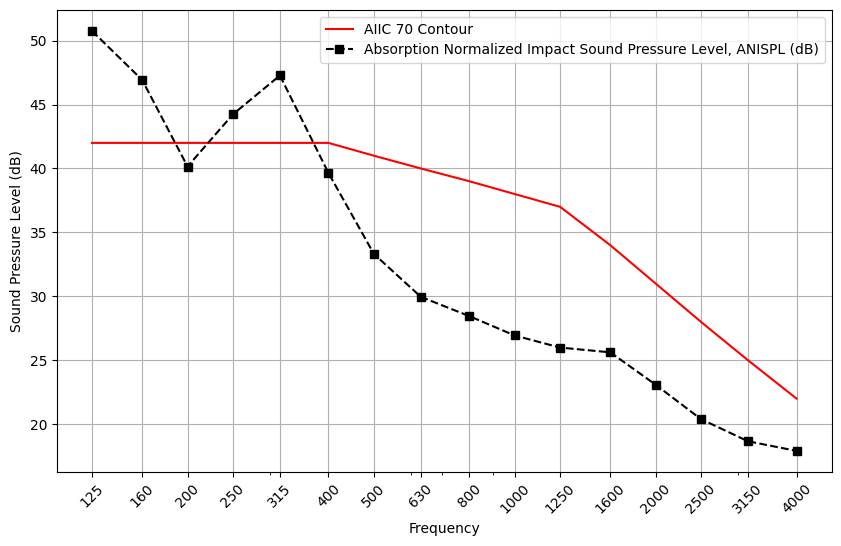

RuntimeError: Too early to create image: no default root window

<Figure size 640x480 with 0 Axes>

In [138]:
def plot_curves(frequencies,Y_label,Ref_curve, Field_curve,Ref_label, Field_label):
    # pass labels for both curves, depending on AIIC or ASTC 
    # AIIC will be Nrec_ANISPL, ASTC will be ATL_val
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, Ref_curve, label=Ref_label, color='red')
    plt.plot(frequencies, Field_curve, label=Field_label, color='black', marker='s', linestyle='--')
    plt.xlabel('Frequency')
    plt.ylabel(Y_label)
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.xticks(frequencies)
    plt.xscale('log')
    plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Format x-ticks as scalars
    plt.gca().xaxis.set_major_locator(ticker.FixedLocator(frequencies))  # Force all x-ticks to display
    # plt.title('Reference vs Measured')
    plt.legend()
    plt.show()
    # fig = plt.figure()
    fig.savefig('plot.png')
    plot_fig = Image('plot.png')
    return plot_fig

frequencies =[125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000]
Ref_label = f'AIIC {AIIC_contour_val} Contour'
IIC_yAxis = 'Sound Pressure Level (dB)'
Field_IIC_label = 'Absorption Normalized Impact Sound Pressure Level, ANISPL (dB)'
plot_fig = plot_curves(frequencies,IIC_yAxis,IIC_contour_final,Nrec_ANISPL,Ref_label, Field_IIC_label)

In [ ]:
# calc AIIC test results and plot
# pull test data from single_test_data
# single_AIIC_test_data

In [2]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from IPython.display import Image

c = canvas.Canvas("example.pdf", pagesize=letter)
textobject = c.beginText()

# Define the text and box position and size
text_x = inch
text_y = letter[1] - 6*inch
box_width = 2*inch
box_height = inch*0.5

# Define the text and font size
text = "ASTC: 32"
font_size = 22

# Calculate the new y position to center the text vertically in the box
text_y_new = text_y + (box_height - font_size) / 2

textobject.setTextOrigin(text_x, text_y_new)
textobject.setFont("Helvetica-Bold", font_size)
textobject.textLines(text)
# plot_img = Image(filename='plot.png')
img_x = inch
img_y = inch
# Add the image to the PDF
# c.drawImage('plot.png', text_x*0.7, text_y, box_width, box_height)
c.drawImage('plot.png', img_x, img_y, 6*inch, 4*inch)
# Draw the text object on the canvas
c.drawText(textobject)

# Draw a rectangle around the text
c.rect(text_x*0.7, text_y, box_width, box_height)

c.save()

In [ ]:
## working on getting single test report to work, here's the path data f
testplan_path ='//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Documents/TestPlan_Kaulu_ASTM_testingv1.xlsx'
Aslmdatapath = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/A_Meter/'
Eslmdatapath = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/E_Meter/'

# output pqth for the report
output_path = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Documents/AutomatedReports/'